## Question 3
(35%) Neural Networks and Gaussian process. 

Predict the SP500 with the financial indicators assigned to your team in the google spreadsheet (ep, dp, de, dy, dfy, bm, svar,
ntis, infl, tbl , see RLab3 2 GWcausalSP500.R), some lagged series of these indicators and lags of the target using a Neural Network and a GP regression with your desired kernel.

Predict return, or price, or direction (up or down). For which target works best? Do some feature selection to disregard some variables, select appropriate lags: causality, (distance) correlation, VAR-test, Lasso ... (The script RLab5 GausProc.R can be of help. The dataset is goyal-welch2022Monthly.csv and work within the period 1927/2021.)

In [219]:
# bm, ep, ntis

In [220]:
# Packages
import os
import pandas as pd
import numpy as np
import random 
from utils import set_seed, regression_metrics, compute_reg_metrics, compute_class_metrics, classification_metrics
from utils import lag_features

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Models
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import statsmodels.api as sm

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings('ignore')

In [221]:
DATA_DIR = 'data'

# Frequency of sampling
tau = 1 #data is monthly. Try tau=12 (year), tau=3 (quarterly)

In [222]:
file = 'goyal-welch2022Monthly.csv'
df = pd.read_csv(os.path.join(DATA_DIR, file)) #,
                   #usecols=['yyyymm', 'Index', 'b/m', 'ep', 'ntis'])

df['Index'] = df['Index'].apply(lambda x: x.replace(',', '')).astype(float)
df['date'] = pd.to_datetime(df['yyyymm'], format='%Y%m')

dateI = "1972-01-01"
dateF = "2021-12-31"
df = df.query(f'date >= "{dateI}" & date <= "{dateF}"')

df['return'] = np.log(df['Index']).diff(tau)

In [223]:
df.columns

Index(['yyyymm', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
       'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx', 'date', 'return'],
      dtype='object')

In [224]:
### Compute dp, de, ep, dy, dfy
# dividend-price ratio (dp)
df['dp'] = np.log(df['D12']) - np.log(df['Index'])
# dividend-payout ratio (de)
df['de'] = np.log(df['D12']) - np.log(df['E12'])
# earnings to price
df['ep'] = np.log(df['E12']) - np.log(df['Index'])
## dividend yield (remove 1st since lag puts NA in 1st entry)
df['dy'] = np.log(df['D12'].shift(-1)) - np.log(df['Index'].shift(-1))
# Default yield spread (dfy)= BAA-AAA rated corporate bond yields:
df['dfy'] = df['BAA'] - df['AAA']  # Assuming 'BAA' and 'AAA' columns are available

df['date'] = pd.to_datetime(df['date']) 
fig = px.line(df, x='date', y='Index', title='Line Plot of Index Over Time')
fig.show()

df['date'] = pd.to_datetime(df['date'])
fig = px.histogram(df, x='Index', nbins=50, title='Histogram of Index')
fig.show()

In [225]:
# Option 2. Target as Return

fig_hist = px.histogram(df, x='return', nbins=50)
fig_hist.update_layout(
    title='Histogram of Returns',
    xaxis_title='Return',
    yaxis_title='Frequency',
    width=1000,
    height=600
)
fig_hist.show()

fig_line = px.line(df, x='date', y='return', title='Returns over', labels={'return': 'Return'})
fig_line.show()


In [226]:
# Option 3. Direction (up or down).
df['direction'] = df['Index'].diff(tau) > 0

df['year'] = (df['yyyymm'] / 100).astype(int)

print(df['direction'].value_counts())

#plt.scatter(df['date'], df['direction'].astype(int), alpha=0.5)
#plt.show()

yearly_direction = df.groupby('year')['direction'].mean().reset_index()

# Create a line plot using plotly.express
fig_line = px.line(yearly_direction, x='year', y='direction', 
                   title='Yearly Mean Direction of Index', labels={'direction': 'Average Direction'})
fig_line.update_layout(
    xaxis_title='Year',
    yaxis_title='Average Direction',
    yaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['Down', 'Up']),  # Adjust as needed
    width=1000,
    height=600
)
fig_line.show()

direction
True     363
False    237
Name: count, dtype: int64


In [227]:
# Select TARGET
type_target = 'return'
if type_target == 'price':
    TARGET = 'Index'
elif type_target == 'return':
    TARGET = 'return'
else:
    TARGET = 'direction'

In [228]:
df.columns

Index(['yyyymm', 'Index', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
       'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'CRSP_SPvw',
       'CRSP_SPvwx', 'date', 'return', 'dp', 'de', 'ep', 'dy', 'dfy',
       'direction', 'year'],
      dtype='object')

['ntis', 'ep', 'b/m', 'E12']
ntis Null Values - 0
ep Null Values - 0
b/m Null Values - 0
E12 Null Values - 0


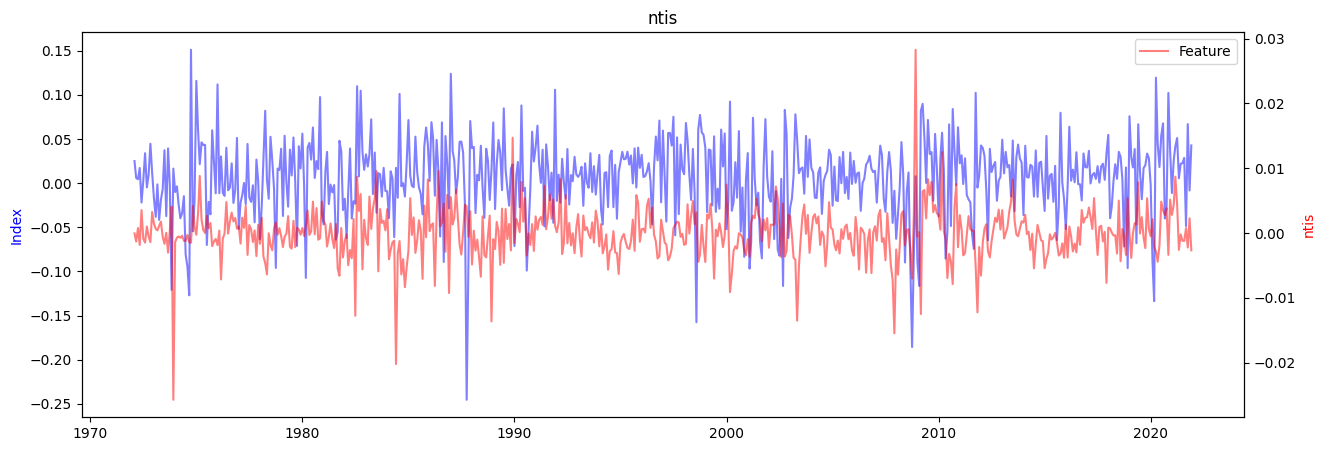

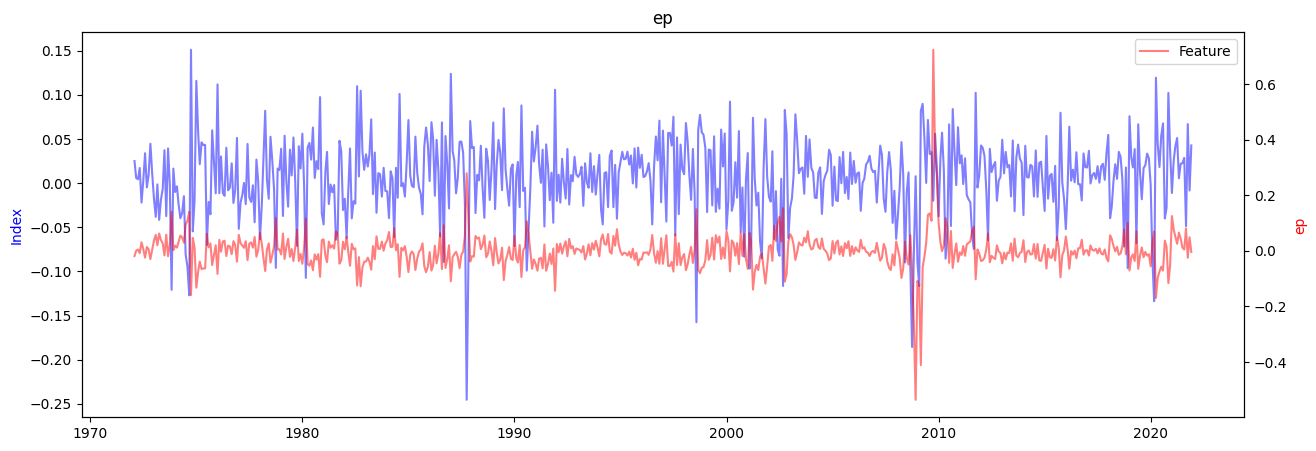

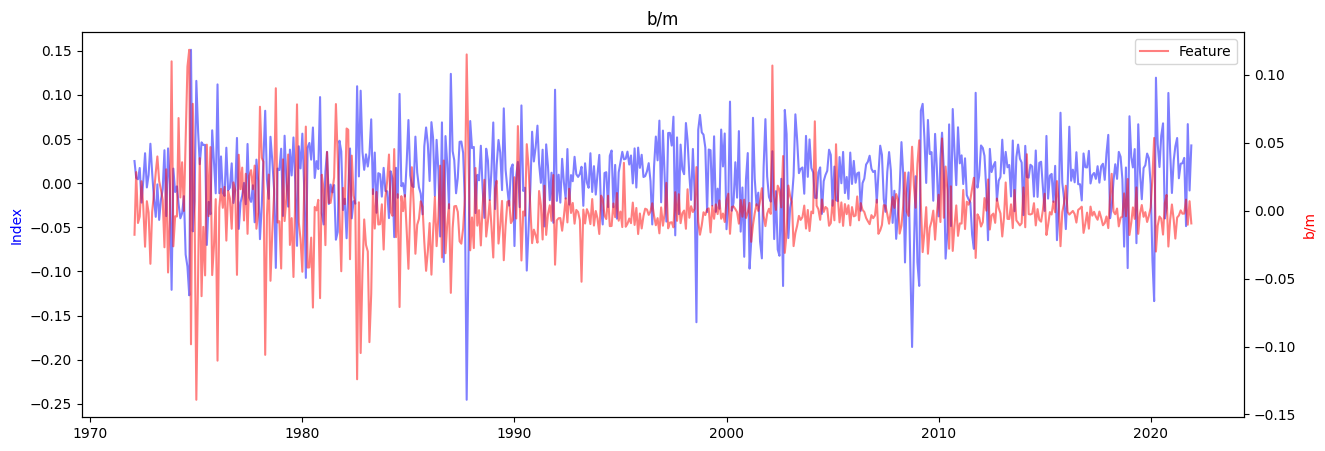

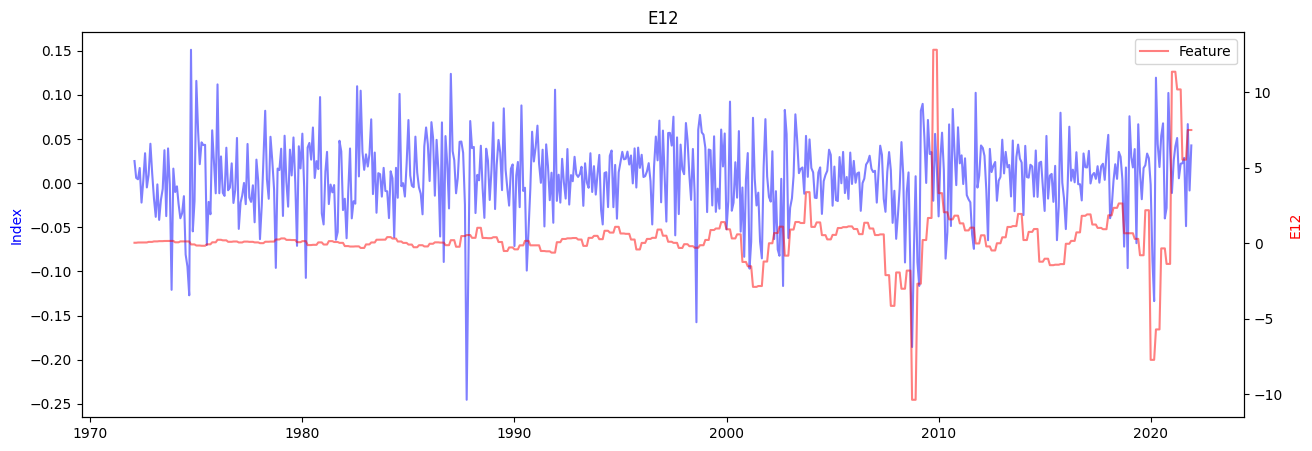

In [263]:
features = list(set(df.columns).intersection(['b/m', 'ntis', 'ep', 'CRSP_SPwx', 'E12']))#, 'E12', 'D12']))
print(features)

## Checking Null Values
for f in features:
    print(f"{f} Null Values - {600 - np.sum(df[f].notnull())}")

for feature in features:
    fig, ax1 = plt.subplots(figsize=(15, 5))
    
    ax1.plot(df['date'], df[TARGET], label='Index', color='blue', alpha=0.5)
    ax1.set_ylabel('Index', color='blue')
    
    ax2 = ax1.twinx()
    if TARGET == 'return':
        ax2.plot(df['date'], df[feature].diff(tau), label='Feature', color='red', alpha=0.5)
    else:
        ax2.plot(df['date'], df[feature], label='Feature', color='red', alpha=0.5)

    ax2.set_ylabel(feature, color='red')

    plt.title(f'{feature}')
    plt.legend()
    plt.show()

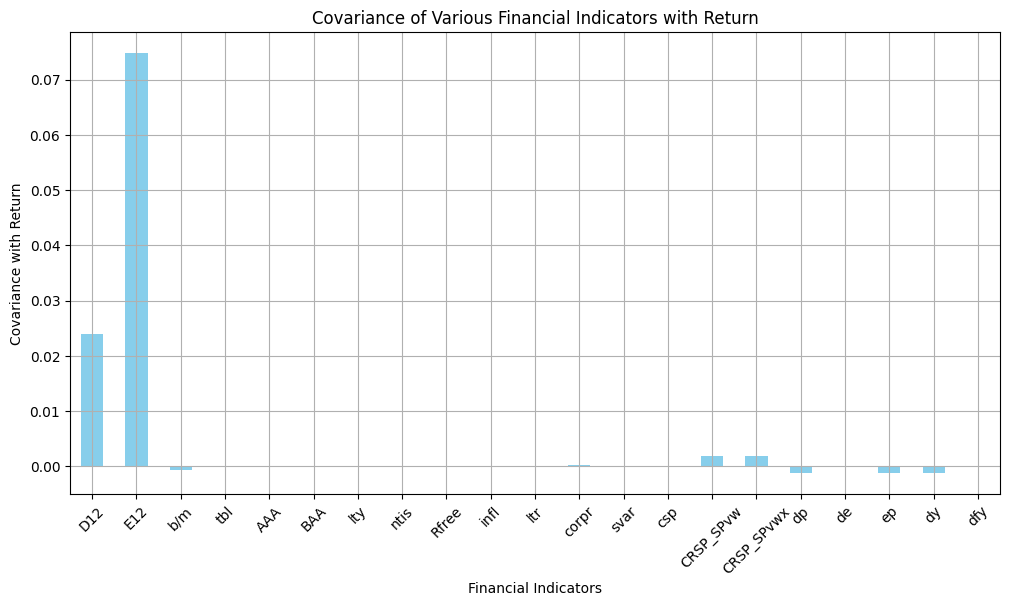

In [264]:
selected_columns = ['D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty',
                    'ntis', 'Rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 
                    'CRSP_SPvw', 'CRSP_SPvwx', 'dp', 'de', 'ep', 
                    'dy', 'dfy', 'return']

cov_matrix = df[selected_columns].cov()

return_covariance = cov_matrix.loc['return'].drop('return')  # Drop self covariance

plt.figure(figsize=(12, 6))
return_covariance.plot(kind='bar', color='skyblue')
plt.title('Covariance of Various Financial Indicators with Return')
plt.xlabel('Financial Indicators')
plt.ylabel('Covariance with Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [265]:
# Model Inputs:
# Define matrix of features (each column is a feature)
# Features: lags 1,2,3 with (or w/o) PE10 and lags 1,2

lags = 5 #Set lags

data = df.set_index('date')[features+[TARGET]]
print(features)

data = lag_features(data, features = features + [TARGET], lags=5)
    

data = data.dropna()
data = data.drop(features, axis = 1)

new_features = list(set(data.columns).difference([TARGET]))

print(new_features)
data.head()

['ntis', 'ep', 'b/m', 'E12']
['ntis_lag5', 'ep_lag4', 'b/m_lag2', 'ntis_lag4', 'return_lag3', 'E12_lag2', 'E12_lag5', 'return_lag5', 'b/m_lag4', 'ntis_lag1', 'E12_lag4', 'b/m_lag3', 'ep_lag3', 'E12_lag3', 'b/m_lag1', 'return_lag4', 'ep_lag2', 'return_lag2', 'ep_lag5', 'b/m_lag5', 'ep_lag1', 'ntis_lag2', 'return_lag1', 'ntis_lag3', 'E12_lag1']


,return,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,E12_lag1,E12_lag2,E12_lag3,E12_lag4,E12_lag5,return_lag1,return_lag2,return_lag3,return_lag4,return_lag5
date,,,,,,,,,,,,,,,,,,,,,
1972-07-01,0.002331,0.034199,0.030657,0.032492,0.031723,0.033030,-2.887389,-2.918420,-2.910358,-2.915116,...,5.9700,5.9167,5.8633,5.8100,5.7733,-0.022062,0.017127,0.004375,0.005894,0.024988
1972-08-01,0.033874,0.033325,0.034199,0.030657,0.032492,0.031723,-2.880267,-2.887389,-2.918420,-2.910358,...,6.0267,5.9700,5.9167,5.8633,5.8100,0.002331,-0.022062,0.017127,0.004375,0.005894
1972-09-01,-0.004873,0.031849,0.033325,0.034199,0.030657,0.032492,-2.904793,-2.880267,-2.887389,-2.918420,...,6.0833,6.0267,5.9700,5.9167,5.8633,0.033874,0.002331,-0.022062,0.017127,0.004375
1972-10-01,0.009274,0.032870,0.031849,0.033325,0.034199,0.030657,-2.890643,-2.904793,-2.880267,-2.887389,...,6.1400,6.0833,6.0267,5.9700,5.9167,-0.004873,0.033874,0.002331,-0.022062,0.017127
1972-11-01,0.044608,0.032353,0.032870,0.031849,0.033325,0.034199,-2.884836,-2.890643,-2.904793,-2.880267,...,6.2333,6.1400,6.0833,6.0267,5.9700,0.009274,-0.004873,0.033874,0.002331,-0.022062


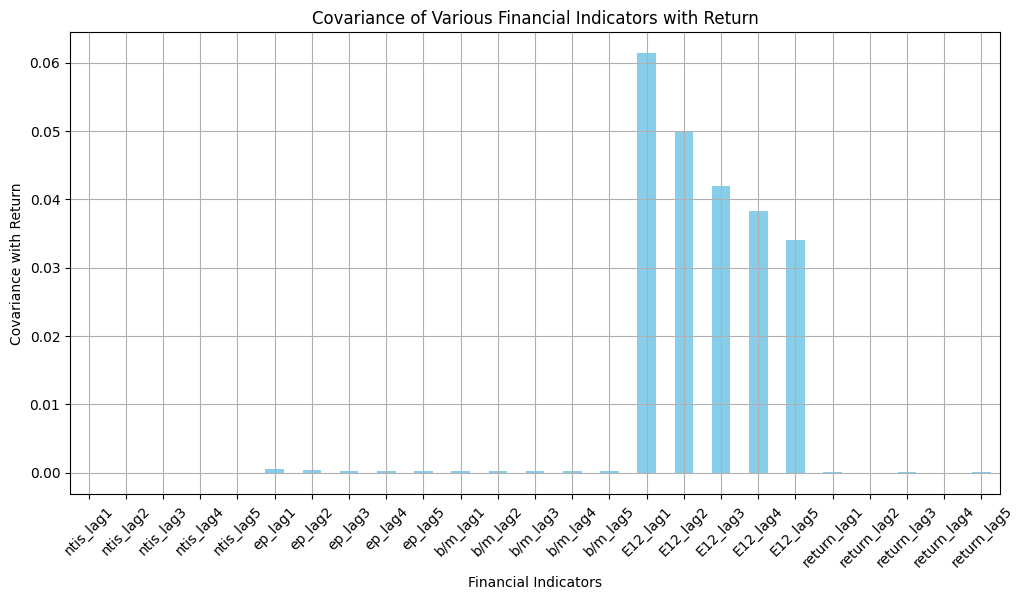

In [266]:
cov_matrix = data.cov()

return_covariance = cov_matrix.loc['return'].drop('return')  # Drop self covariance

plt.figure(figsize=(12, 6))
return_covariance.plot(kind='bar', color='skyblue')
plt.title('Covariance of Various Financial Indicators with Return')
plt.xlabel('Financial Indicators')
plt.ylabel('Covariance with Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [267]:
# Time Series Train test split
T = len(data)
p = 0.75
trainindex = round(p*T)

# process class sets as data frames
training = data.iloc[:trainindex, :]
testing = data.iloc[trainindex:, :]

display(training.tail())
display(testing.head())

X_train, y_train = training[new_features], training[TARGET]
X_test, y_test = testing[new_features], testing[TARGET]

,return,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,E12_lag1,E12_lag2,E12_lag3,E12_lag4,E12_lag5,return_lag1,return_lag2,return_lag3,return_lag4,return_lag5
date,,,,,,,,,,,,,,,,,,,,,
2009-04-01,0.089772,-0.037427,-0.024927,-0.025056,-0.024498,-0.052780,-4.756238,-4.345202,-4.214465,-4.105981,...,6.8600,9.5333,12.2067,14.8800,25.2367,0.081953,-0.116457,-0.089550,0.007791,-0.077798
2009-05-01,0.051721,-0.030993,-0.037427,-0.024927,-0.025056,-0.024498,-4.814910,-4.756238,-4.345202,-4.214465,...,7.0767,6.8600,9.5333,12.2067,14.8800,0.089772,0.081953,-0.116457,-0.089550,0.007791
2009-06-01,0.000196,-0.024349,-0.030993,-0.037427,-0.024927,-0.025056,-4.836482,-4.814910,-4.756238,-4.345202,...,7.2933,7.0767,6.8600,9.5333,12.2067,0.051721,0.089772,0.081953,-0.116457,-0.089550
2009-07-01,0.071522,-0.022097,-0.024349,-0.030993,-0.037427,-0.024927,-4.807399,-4.836482,-4.814910,-4.756238,...,7.5100,7.2933,7.0767,6.8600,9.5333,0.000196,0.051721,0.089772,0.081953,-0.116457
2009-08-01,0.033009,-0.013782,-0.022097,-0.024349,-0.030993,-0.037427,-4.677399,-4.807399,-4.836482,-4.814910,...,9.1867,7.5100,7.2933,7.0767,6.8600,0.071522,0.000196,0.051721,0.089772,0.081953


,return,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,E12_lag1,E12_lag2,E12_lag3,E12_lag4,E12_lag5,return_lag1,return_lag2,return_lag3,return_lag4,return_lag5
date,,,,,,,,,,,,,,,,,,,,,
2009-09-01,0.035100,-0.007921,-0.013782,-0.022097,-0.024349,-0.030993,-4.542775,-4.677399,-4.807399,-4.836482,...,10.8633,9.1867,7.5100,7.2933,7.0767,0.033009,0.071522,0.000196,0.051721,0.089772
2009-10-01,-0.019960,-0.000014,-0.007921,-0.013782,-0.022097,-0.024349,-4.434342,-4.542775,-4.677399,-4.807399,...,12.5400,10.8633,9.1867,7.5100,7.2933,0.035100,0.033009,0.071522,0.000196,0.051721
2009-11-01,0.055779,0.003198,-0.000014,-0.007921,-0.013782,-0.022097,-3.710527,-4.434342,-4.542775,-4.677399,...,25.3500,12.5400,10.8633,9.1867,7.5100,-0.019960,0.035100,0.033009,0.071522,0.000196
2009-12-01,0.017615,0.007532,0.003198,-0.000014,-0.007921,-0.013782,-3.357297,-3.710527,-4.434342,-4.542775,...,38.1600,25.3500,12.5400,10.8633,9.1867,0.055779,-0.019960,0.035100,0.033009,0.071522
2010-01-01,-0.037675,0.010594,0.007532,0.003198,-0.000014,-0.007921,-3.085462,-3.357297,-3.710527,-4.434342,...,50.9700,38.1600,25.3500,12.5400,10.8633,0.017615,0.055779,-0.019960,0.035100,0.033009


### Model Selection with LASSO

In [268]:
scaler = StandardScaler()
columns = X_train.columns

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = columns)
X_test = pd.DataFrame(X_test, columns = columns)

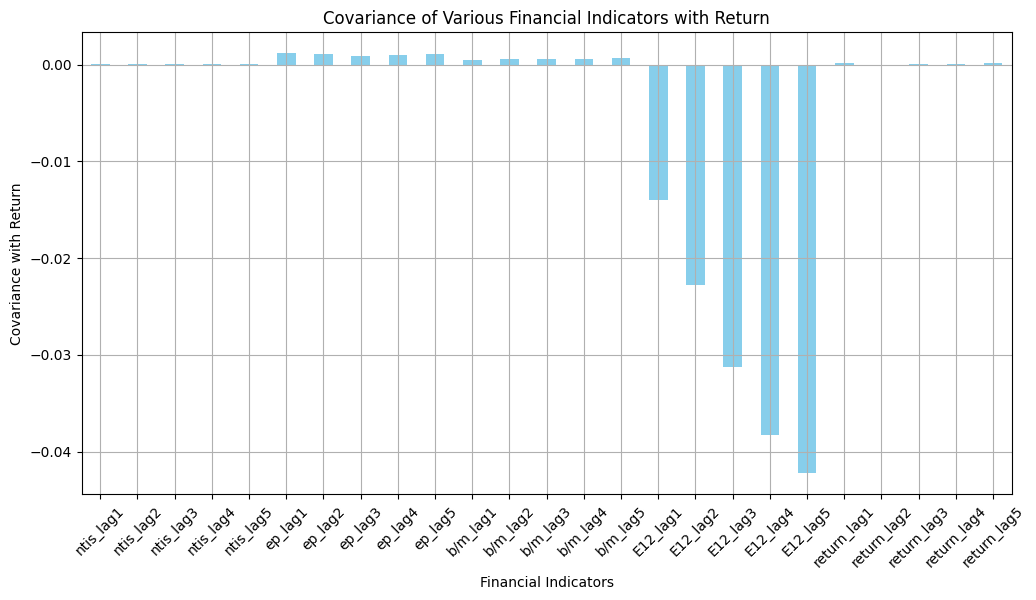

In [269]:
training["return"] = y_train
cov_matrix = training.cov()

return_covariance = cov_matrix.loc['return'].drop('return')

plt.figure(figsize=(12, 6))
return_covariance.plot(kind='bar', color='skyblue')
plt.title('Covariance of Various Financial Indicators with Return')
plt.xlabel('Financial Indicators')
plt.ylabel('Covariance with Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [236]:
lasso = Lasso()
params = {
    "alpha": np.logspace(-12,-1, 20)
}
lasso_gridsearch = GridSearchCV(lasso, params)

lasso_gridsearch.fit(X_train, y_train)
lasso_gridsearch.best_estimator_


Lasso(alpha=0.006951927961775619)

In [237]:
lasso = Lasso(alpha = 0.006952)
lasso.fit(X_train, y_train)

Lasso(alpha=0.006952)

In [238]:
X_train.columns[lasso.coef_ != 0]

Index([], dtype='object')

# Estimating Return

## Setting ARMA as Baseline

In [239]:
df['date'] = pd.to_datetime(df['date'])
data = df.set_index('date')
data.index = pd.DatetimeIndex(data.index, freq='MS') 

split = round(len(df)*0.8)  # Make sure it's data not df if df is not used afterward
return_train = data["return"][:split]  # Assuming 'return' is the column you're analyzing
return_test = data["return"][split:]

'''
def objective(trial):
    p = trial.suggest_int('p', 1, 20)
    q = trial.suggest_int('q', 1, 20)

    try:
        model = sm.tsa.arima.ARIMA(return_train, order=(p, 0, q))  # d=0 fixed as per your scenario
        result = model.fit()
    except Exception as e:
        print(e)
        return np.inf

    forecast_result = result.get_forecast(steps=len(return_test))
    forecast_mean = forecast_result.predicted_mean

    mse = mean_squared_error(return_test, forecast_mean)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"MSE: {trial.value}")
print(f"Optimal parameters: p={trial.params['p']}, q={trial.params['q']}")
'''

'\ndef objective(trial):\n    p = trial.suggest_int(\'p\', 1, 20)\n    q = trial.suggest_int(\'q\', 1, 20)\n\n    try:\n        model = sm.tsa.arima.ARIMA(return_train, order=(p, 0, q))  # d=0 fixed as per your scenario\n        result = model.fit()\n    except Exception as e:\n        print(e)\n        return np.inf\n\n    forecast_result = result.get_forecast(steps=len(return_test))\n    forecast_mean = forecast_result.predicted_mean\n\n    mse = mean_squared_error(return_test, forecast_mean)\n    return mse\n\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=100)\n\nprint("Best trial:")\ntrial = study.best_trial\nprint(f"MSE: {trial.value}")\nprint(f"Optimal parameters: p={trial.params[\'p\']}, q={trial.params[\'q\']}")\n'

In [240]:
order = (7, 0, 7)
model = sm.tsa.arima.ARIMA(return_train, order=order)
arma_result = model.fit()

n_forecast_steps = len(return_test)

forecast_result = arma_result.get_forecast(steps=n_forecast_steps)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

print(f"Baseline Error: {mean_squared_error(forecast_mean, return_test)}")

Baseline Error: 0.0014350552662253165


In [241]:
trace_true = go.Scatter(
    x = return_test.index,
    y = return_test,
    mode = 'lines',
    name = 'True'
)

trace_pred = go.Scatter(
    x = return_test.index,
    y = forecast_result.predicted_mean,
    mode = 'lines',
    name = 'Predicted'
)

fig = go.Figure(data=[trace_true, trace_pred])

fig.update_layout(
    title='True vs Predicted Values',
    xaxis_title='Year',
    yaxis_title='Index',
    legend_title='Legend',
    width=1000,
    height=600  
)

fig.show()

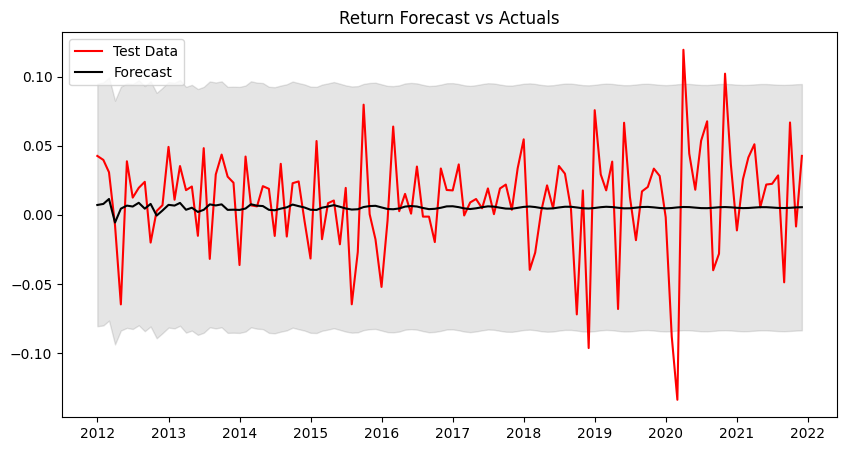

In [242]:
plt.figure(figsize=(10, 5))

plt.plot(return_test.index, return_test, label='Test Data', color='r')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='k')

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.1)

plt.title('Return Forecast vs Actuals')
plt.legend()
plt.show()

# Gaussian Process

These numbers represent hyperparameters and settings for Gaussian process (GP) regression using scikit-learn in Python:

- l: Length scale parameter for the squared exponential (SE) kernel. It controls the smoothness of the GP function. In this case, l = 0.003.
- C(1.5, (1e-3, 1e3)): Constant kernel with a constant value of 1.5 and bounds for optimization between 1e-3 and 1e3. This kernel adds a constant value to the diagonal of the kernel matrix, improving numerical stability.
- RBF(l, (1e-2, 1e2)): Radial basis function (RBF) kernel with a length scale of l and bounds for optimization between 1e-2 and 1e2. The RBF kernel, also known as the squared exponential kernel, is commonly used for modeling stationary processes.

These hyperparameters and settings are used to define the Gaussian process regressor (gaussian_process.GaussianProcessRegressor). The regressor is configured with the defined kernel (MyKer), an initial noise variance of 0.003 (alpha), normalization of the target values (normalize_y=True), 10 restarts for optimizer to find the maximum likelihood parameters (n_restarts_optimizer=10), and a random state for reproducibility (random_state=0).

In [243]:
# GP Kernel: vanilla is non-stationary; tanh, rbf are stationary
# Define my own Kernel (for vectors). You have 3 choices below:
# SE kernel with length scale l
l = 0.003  # 0.15, 0.3
MyKer = C(1.5, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

# Define the Gaussian Process Regressor
gpfit = gaussian_process.GaussianProcessRegressor(
    kernel=MyKer,
    alpha=0.003,  # the initial noise variance: 0.001 default min value
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=0,
)

gpfit.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.003, kernel=1.22**2 * RBF(length_scale=0.003),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=0)

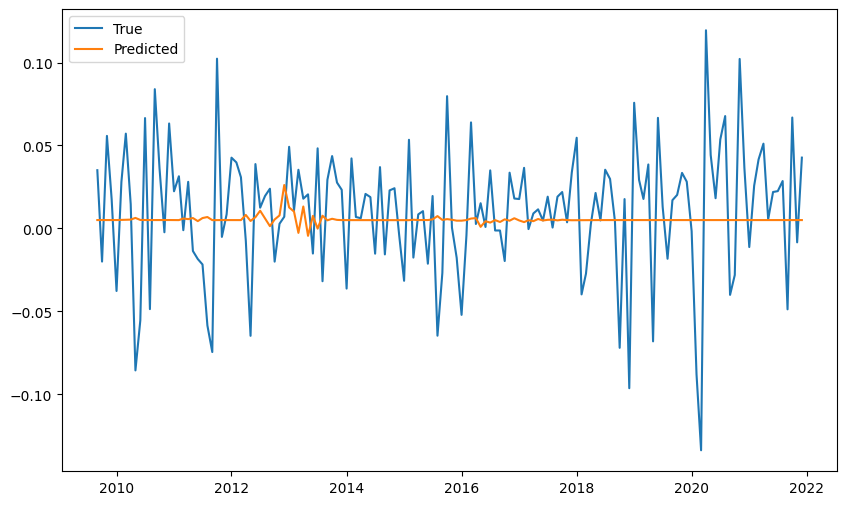

In [244]:
# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': gpfit.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

In [245]:
regression_metrics(y_train, gpfit.predict(X_train), 
                   y_test, gpfit.predict(X_test)) 

 --- TRAIN --- 
 R2: 0.99999
 RMSE: 0.0
 --- TEST --- 
 R2: -0.02746
 RMSE: 0.001608
 Gap RMSE: 0.001608


# How do we find the best parameters of the Gaussian Process? 
=> Optuna

In [246]:
# Create validation to evaluate performance
T = len(training)
p = 0.75
validindex = round(p*T)

# process class sets as data frames
training_ = training.iloc[:validindex, :]
valid_ = training.iloc[validindex:, :]

X_train_, y_train_ = training_[new_features], training_[TARGET]
X_valid, y_valid = valid_[new_features], valid_[TARGET]

In [247]:
import optuna

# Define the objective function
def objective(trial):
    # Define hyperparameters to be optimized
    l = trial.suggest_loguniform('l', 1e-3, 1e1)
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    C_value = trial.suggest_float('C_value', 0.5, 3)
    
    # Define the kernel
    MyKer = C(C_value, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

    # Define the Gaussian Process Regressor with optimized hyperparameters
    gpfit = gaussian_process.GaussianProcessRegressor(
        kernel=MyKer,
        alpha=alpha,
        normalize_y=True,
        n_restarts_optimizer=10,
        random_state=0,
    )

    # Fit the GP regressor
    gpfit.fit(X_train_, y_train_)

    # Predict on the validation set
    y_pred = gpfit.predict(X_valid)

    # Calculate the mean squared error
    score = mean_squared_error(y_valid, y_pred)
    #score = r2_score(y_valid, y_pred)

    return score

# Define X_val and y_val for validation
# You need to define X_train and y_train as well

# Define study and optimize the objective function
study = optuna.create_study(direction='minimize') # 'maximize' for R2 | 'minimize' for RMSE
study.optimize(objective, n_trials=60)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-05-02 16:47:27,815] A new study created in memory with name: no-name-d800593b-3b7e-404c-a5ce-7004ceae83f9
[I 2024-05-02 16:47:30,038] Trial 0 finished with value: 0.0023417174775373184 and parameters: {'l': 7.844389337956982, 'alpha': 0.05147464194851104, 'C_value': 2.1881991431557326}. Best is trial 0 with value: 0.0023417174775373184.
[I 2024-05-02 16:47:31,695] Trial 1 finished with value: 0.0023417174775373184 and parameters: {'l': 0.34627888713890637, 'alpha': 0.003264569896078535, 'C_value': 2.0824576601335227}. Best is trial 0 with value: 0.0023417174775373184.
[I 2024-05-02 16:47:33,428] Trial 2 finished with value: 0.0023417174775373184 and parameters: {'l': 0.010915113389790676, 'alpha': 0.025809605979775257, 'C_value': 2.0720053603404183}. Best is trial 0 with value: 0.0023417174775373184.
[I 2024-05-02 16:47:35,149] Trial 3 finished with value: 0.0023417174775373184 and parameters: {'l': 0.004946661212040118, 'alpha': 0.05067392467300347, 'C_value': 1.42228358716640

Best hyperparameters: {'l': 7.844389337956982, 'alpha': 0.05147464194851104, 'C_value': 2.1881991431557326}


In [250]:
fig = optuna.visualization.plot_optimization_history(study, target_name='Validation CRPS')
fig.update_layout(autosize=True, width=800, height=500)
fig.show()

In [251]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(autosize=True, width=800, height=400)
fig.show()

RuntimeError: Encountered zero total variance in all trees.

In [252]:
params = study.best_params

MyKer = C(params['C_value'], (1e-3, 1e3)) * RBF(params['l'], (1e-2, 1e2))

# Define the Gaussian Process Regressor
gpfit = gaussian_process.GaussianProcessRegressor(
    kernel=MyKer,
    alpha=params['alpha'],  # the initial noise variance: 0.001 default min value
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=0,
)

gpfit.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.05147464194851104,
                         kernel=1.48**2 * RBF(length_scale=7.84),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=0)

In [253]:
regression_metrics(y_train, gpfit.predict(X_train), 
                   y_test, gpfit.predict(X_test)) 

 --- TRAIN --- 
 R2: 0.99716
 RMSE: 6e-06
 --- TEST --- 
 R2: -0.02604
 RMSE: 0.001606
 Gap RMSE: 0.0016


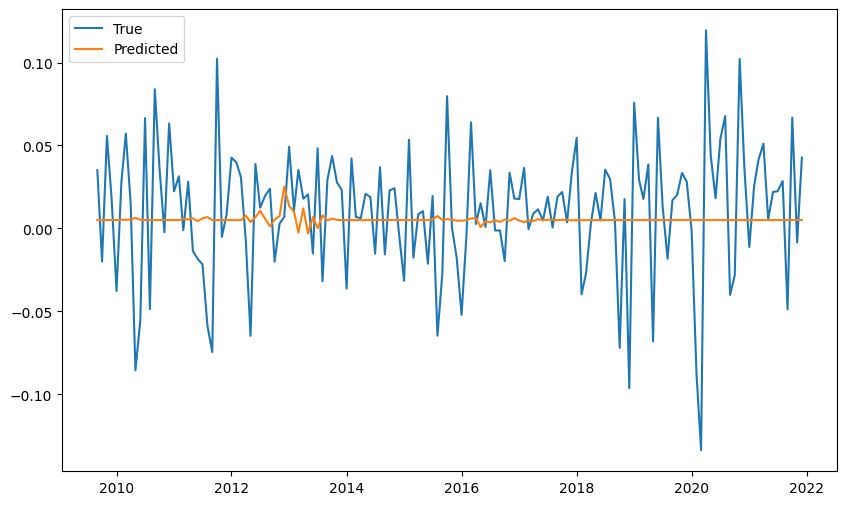

In [254]:
# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': gpfit.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

# Neural Network

In [297]:
set_seed(1234)

In [298]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(25, 40) 
        self.fc2 = nn.Linear(40, 40) 
        self.fc3 = nn.Linear(40, 40) 
        self.fc4 = nn.Linear(40, 1)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x) 
        return x

model = FCN()

In [299]:
#inputs = torch.from_numpy(X_train_scaled).float()
#targets = torch.from_numpy(np.array(y_train)).float()

inputs = torch.from_numpy(np.array(X_train)).float()
targets = torch.from_numpy(np.array(y_train)).float()

In [300]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 500

tolerance = 1e-6
last_loss = float('inf')

for epoch in range(num_epochs):
    total_loss = 0
    for i in range(inputs.size(0)):
        
        outputs = model(inputs[i].unsqueeze(0))

        loss = criterion(outputs, targets[i].unsqueeze(0)) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    average_loss = total_loss/inputs.size(0)
        
    if abs(last_loss - average_loss) < tolerance:
        print(f"Stopping early at epoch {epoch+1}")
        break

    last_loss = average_loss

    average_loss = total_loss / inputs.size(0)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')
    scheduler.step()

Epoch [10/500], Average Loss: 0.0017
Epoch [20/500], Average Loss: 0.0016
Epoch [30/500], Average Loss: 0.0015
Stopping early at epoch 38


In [301]:
test_tensor = torch.from_numpy(np.array(X_test)).float()
insample_predict = model(inputs).detach().numpy()
outsample_predict = model(test_tensor).detach().numpy()

regression_metrics(y_train, insample_predict, 
                   y_test, outsample_predict) 

# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': outsample_predict.flatten()})

# Plot the results
trace_true = go.Scatter(
    x = df_res.index,
    y = df_res['true'],
    mode = 'lines',
    name = 'True'
)

trace_pred = go.Scatter(
    x = df_res.index,
    y = df_res['pred'],
    mode = 'lines',
    name = 'Predicted'
)

fig = go.Figure(data=[trace_true, trace_pred])

fig.update_layout(
    title='True vs Predicted Values',
    xaxis_title='Year',
    yaxis_title='Index',
    legend_title='Legend',
    width=1000,
    height=600  
)

# Show the figure
fig.show()

 --- TRAIN --- 
 R2: 0.27673
 RMSE: 0.001503
 --- TEST --- 
 R2: -0.90312
 RMSE: 0.002979
 Gap RMSE: 0.0014759999999999999


 --- TRAIN --- 
 R2: -0.00769
 RMSE: 0.002094
 --- TEST --- 
 R2: -2.14185
 RMSE: 0.004918
 Gap RMSE: 0.0028239999999999997


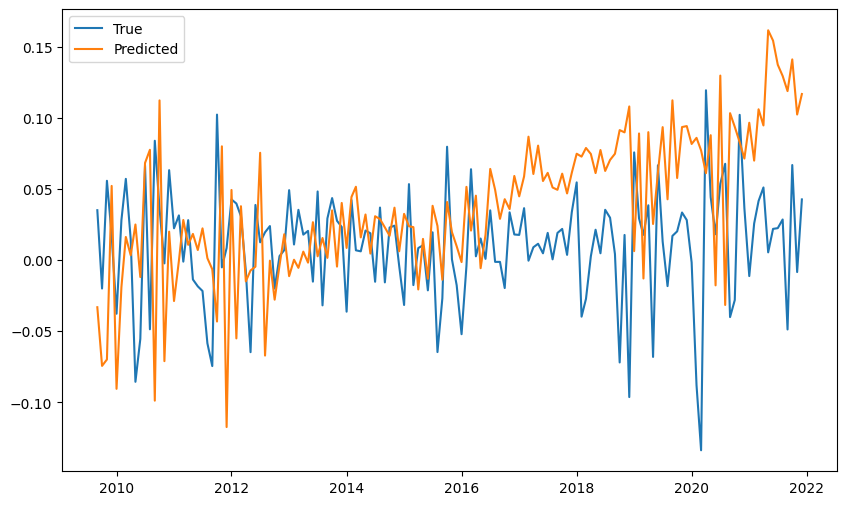

In [287]:
size = 40
mlp1 = 0(
    hidden_layer_sizes=(size, size, size),
    max_iter=100000,
    activation="relu", #"logistic", # "tanh", "relu"
    solver="adam" # "lbfgs", "sgd"
)

mlp1.fit(X_train, y_train)

regression_metrics(y_train, mlp1.predict(X_train), 
                   y_test, mlp1.predict(X_test)) 

# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': mlp1.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

 --- TRAIN --- 
 R2: 0.49608
 RMSE: 0.001047
 --- TEST --- 
 R2: -1.08339
 RMSE: 0.003261
 Gap RMSE: 0.002214


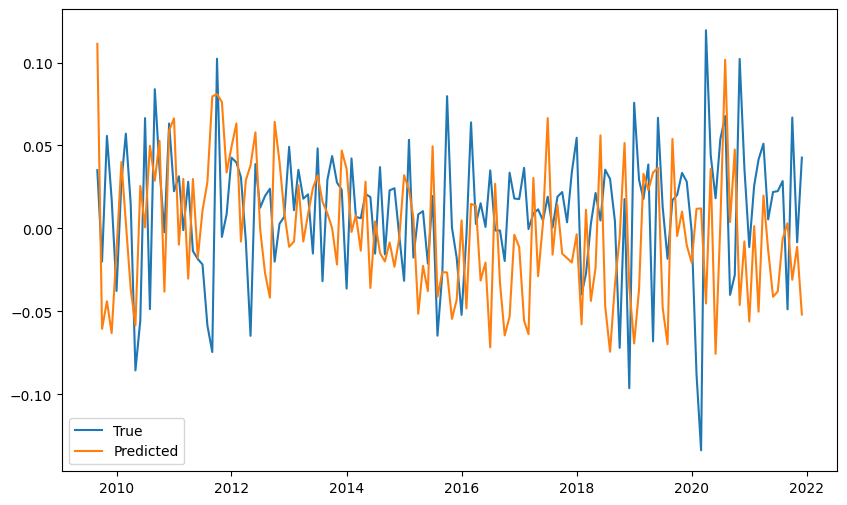

In [ ]:
# Alternative using nnet with one hidden layer with size many nodes + skip layer
# Parameters to tune: size, weight decay (a regularization of tyoe L2 in penalty funct that shrinks weights)
size = 500
decay = 10 ** -2
mlp2 = MLPRegressor(
    hidden_layer_sizes=(size,), 
    max_iter=10000, 
    alpha=decay
)

mlp2.fit(X_train, y_train)

regression_metrics(y_train, mlp2.predict(X_train), 
                   y_test, mlp2.predict(X_test)) 

# Evaluation of Results
df_res = pd.DataFrame({'true': testing[TARGET], 'pred': mlp2.predict(X_test)})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_res['true'], label='True')
plt.plot(df_res['pred'], label='Predicted')
plt.legend()
plt.show()

# Binary classification

In [302]:
def lag_features(df, features, lags):
    df_ = df.copy()
    
    if isinstance(lags, int):
        for feature in features:
            for lag in range(1, lags + 1):
                df_[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    elif isinstance(lags, list):
        if len(features) != len(lags):
            raise ValueError("Length of 'features' and 'lags' must match when 'lags' is a list.")
        for feature, lag in zip(features, lags):
            for l in range(1, lag + 1):
                df_[f'{feature}_lag{l}'] = df[feature].shift(l)
    else:
        raise TypeError("Lags must be either an integer or a list of integers.")
    
    return df_

In [303]:
lags = 5
TARGET = 'direction'
data = df.set_index('date')[features+['return', TARGET]]
print(features)


data = lag_features(df = data, features=features+[TARGET], lags = 5)


data = data.dropna()
data = data.drop("return", axis = 1)
data = data.drop(features, axis = 1)

new_features = list(set(data.columns).difference(['return', TARGET]))
print(new_features)

data.head()

['ntis', 'ep', 'b/m', 'E12']
['ntis_lag5', 'ep_lag4', 'b/m_lag2', 'ntis_lag4', 'E12_lag2', 'E12_lag5', 'b/m_lag4', 'ntis_lag1', 'direction_lag3', 'E12_lag4', 'b/m_lag3', 'ep_lag3', 'E12_lag3', 'b/m_lag1', 'direction_lag2', 'direction_lag4', 'direction_lag1', 'direction_lag5', 'ep_lag2', 'ep_lag5', 'b/m_lag5', 'ep_lag1', 'ntis_lag2', 'ntis_lag3', 'E12_lag1']


,direction,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,E12_lag1,E12_lag2,E12_lag3,E12_lag4,E12_lag5,direction_lag1,direction_lag2,direction_lag3,direction_lag4,direction_lag5
date,,,,,,,,,,,,,,,,,,,,,
1972-06-01,False,0.030657,0.032492,0.031723,0.033030,0.033075,-2.918420,-2.910358,-2.915116,-2.915558,...,5.9167,5.8633,5.8100,5.7733,5.7367,True,True,True,True,False
1972-07-01,True,0.034199,0.030657,0.032492,0.031723,0.033030,-2.887389,-2.918420,-2.910358,-2.915116,...,5.9700,5.9167,5.8633,5.8100,5.7733,False,True,True,True,True
1972-08-01,True,0.033325,0.034199,0.030657,0.032492,0.031723,-2.880267,-2.887389,-2.918420,-2.910358,...,6.0267,5.9700,5.9167,5.8633,5.8100,True,False,True,True,True
1972-09-01,False,0.031849,0.033325,0.034199,0.030657,0.032492,-2.904793,-2.880267,-2.887389,-2.918420,...,6.0833,6.0267,5.9700,5.9167,5.8633,True,True,False,True,True
1972-10-01,True,0.032870,0.031849,0.033325,0.034199,0.030657,-2.890643,-2.904793,-2.880267,-2.887389,...,6.1400,6.0833,6.0267,5.9700,5.9167,False,True,True,False,True


In [304]:
# Time Series Train test split
T = len(data)
p = 0.75
trainindex = round(p*T)

# process class sets as data frames
training = data.iloc[:trainindex, :]
testing = data.iloc[trainindex:, :]

display(training.tail())
display(testing.head())

X_train, y_train = training[new_features], training[TARGET]
X_test, y_test = testing[new_features], testing[TARGET]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

,direction,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,E12_lag1,E12_lag2,E12_lag3,E12_lag4,E12_lag5,direction_lag1,direction_lag2,direction_lag3,direction_lag4,direction_lag5
date,,,,,,,,,,,,,,,,,,,,,
2009-03-01,True,-0.024927,-0.025056,-0.024498,-0.052780,-0.055954,-4.345202,-4.214465,-4.105981,-3.569909,...,9.5333,12.2067,14.8800,25.2367,35.5933,False,False,True,False,False
2009-04-01,True,-0.037427,-0.024927,-0.025056,-0.024498,-0.052780,-4.756238,-4.345202,-4.214465,-4.105981,...,6.8600,9.5333,12.2067,14.8800,25.2367,True,False,False,True,False
2009-05-01,True,-0.030993,-0.037427,-0.024927,-0.025056,-0.024498,-4.814910,-4.756238,-4.345202,-4.214465,...,7.0767,6.8600,9.5333,12.2067,14.8800,True,True,False,False,True
2009-06-01,True,-0.024349,-0.030993,-0.037427,-0.024927,-0.025056,-4.836482,-4.814910,-4.756238,-4.345202,...,7.2933,7.0767,6.8600,9.5333,12.2067,True,True,True,False,False
2009-07-01,True,-0.022097,-0.024349,-0.030993,-0.037427,-0.024927,-4.807399,-4.836482,-4.814910,-4.756238,...,7.5100,7.2933,7.0767,6.8600,9.5333,True,True,True,True,False


,direction,ntis_lag1,ntis_lag2,ntis_lag3,ntis_lag4,ntis_lag5,ep_lag1,ep_lag2,ep_lag3,ep_lag4,...,E12_lag1,E12_lag2,E12_lag3,E12_lag4,E12_lag5,direction_lag1,direction_lag2,direction_lag3,direction_lag4,direction_lag5
date,,,,,,,,,,,,,,,,,,,,,
2009-08-01,True,-0.013782,-0.022097,-0.024349,-0.030993,-0.037427,-4.677399,-4.807399,-4.836482,-4.814910,...,9.1867,7.5100,7.2933,7.0767,6.8600,True,True,True,True,True
2009-09-01,True,-0.007921,-0.013782,-0.022097,-0.024349,-0.030993,-4.542775,-4.677399,-4.807399,-4.836482,...,10.8633,9.1867,7.5100,7.2933,7.0767,True,True,True,True,True
2009-10-01,False,-0.000014,-0.007921,-0.013782,-0.022097,-0.024349,-4.434342,-4.542775,-4.677399,-4.807399,...,12.5400,10.8633,9.1867,7.5100,7.2933,True,True,True,True,True
2009-11-01,True,0.003198,-0.000014,-0.007921,-0.013782,-0.022097,-3.710527,-4.434342,-4.542775,-4.677399,...,25.3500,12.5400,10.8633,9.1867,7.5100,False,True,True,True,True
2009-12-01,True,0.007532,0.003198,-0.000014,-0.007921,-0.013782,-3.357297,-3.710527,-4.434342,-4.542775,...,38.1600,25.3500,12.5400,10.8633,9.1867,True,False,True,True,True


## Random Classificer Baseline

In [368]:
class_breakdown = y_train.value_counts()/y_train.size
p = class_breakdown[0]

random_predict= [1 if np.random.rand() < p else 0 for i in range(len(y_test))]

In [370]:

classification_metrics(y_train, insample_predict, 
                    y_test, random_predict) 

 --- TRAIN --- 
 Accuracy: 0.80493
 Precision: 0.79791
 Recall: 0.8876
 F1-score: 0.84037
 --- TEST --- 
 Accuracy: 0.5302
 Precision: 0.66316
 Recall: 0.62376
 F1-score: 0.64286


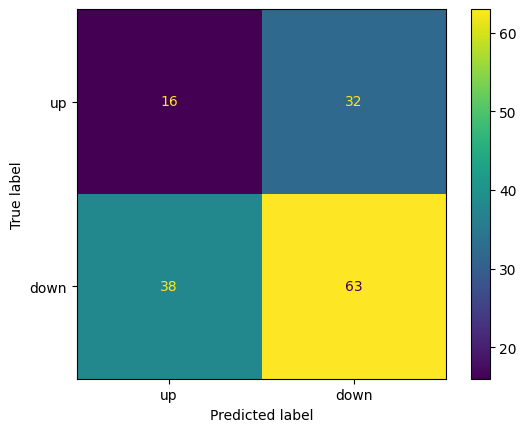

In [369]:
cm = confusion_matrix(y_test, random_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up', 'down'])
disp.plot()
plt.show()

In [371]:
majority_predict = [1] * len(y_test)

In [373]:

classification_metrics(y_train, insample_predict, 
                    y_test, majority_predict) 

 --- TRAIN --- 
 Accuracy: 0.80493
 Precision: 0.79791
 Recall: 0.8876
 F1-score: 0.84037
 --- TEST --- 
 Accuracy: 0.67785
 Precision: 0.67785
 Recall: 1.0
 F1-score: 0.808


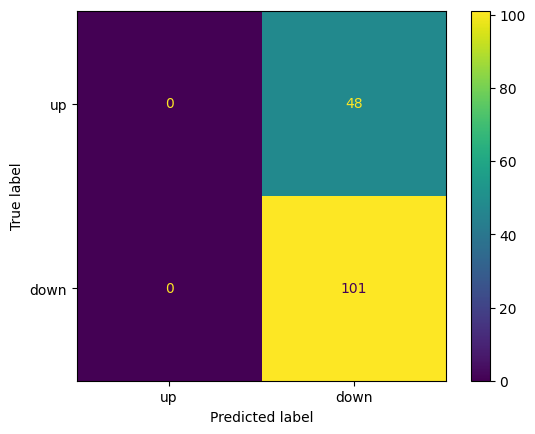

In [372]:
cm = confusion_matrix(y_test, majority_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up', 'down'])
disp.plot()
plt.show()

# Gaussian Process

In [350]:
# GP Kernel: vanilla is non-stationary; tanh, rbf are stationary
# Define my own Kernel (for vectors). You have 3 choices below:
# SE kernel with length scale l
l = 0.003  # 0.15, 0.3
MyKer = C(1.5, (1e-3, 1e3)) * RBF(l, (1e-2, 1e2))

# Define the Gaussian Process Regressor
class_gpfit = gaussian_process.GaussianProcessClassifier(
    kernel=MyKer,
    n_restarts_optimizer=10,
    random_state=0,
)

class_gpfit.fit(X_train, y_train)

# Does Gaussian Process has predict_proba??

GaussianProcessClassifier(kernel=1.22**2 * RBF(length_scale=0.003),
                          n_restarts_optimizer=10, random_state=0)

In [352]:
from joblib import dump, load

dump(class_gpfit, 'gp_classifier.joblib')
class_gpfit = load('gp_classifier.joblib')

In [353]:
classification_metrics(y_train, class_gpfit.predict(X_train), 
                   y_test, class_gpfit.predict(X_test)) 

 --- TRAIN --- 
 Accuracy: 0.66816
 Precision: 0.65988
 Recall: 0.87984
 F1-score: 0.75415
 --- TEST --- 
 Accuracy: 0.65772
 Precision: 0.67606
 Recall: 0.9505
 F1-score: 0.79012


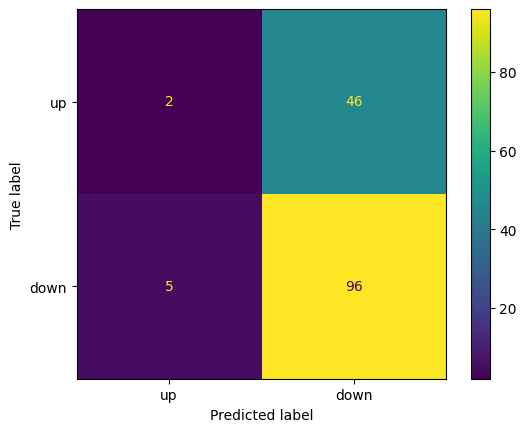

In [354]:
cm = confusion_matrix(y_test, class_gpfit.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up', 'down'])
disp.plot()
plt.show()

## NNet

In [345]:
class binary_nnet(nn.Module):
    def __init__(self):
        super(binary_nnet, self).__init__()
        self.fc1 = nn.Linear(25, 40) 
        self.fc2 = nn.Linear(40, 40) 
        self.fc3 = nn.Linear(40, 40) 
        self.fc4 = nn.Linear(20, 10)
        self.fc5 = nn.Linear(40, 1)
        # Activation function
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.relu(self.fc3(x))
        #x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

model = binary_nnet()

In [346]:
inputs = torch.from_numpy(np.array(X_train).astype(float)).float()
targets = torch.from_numpy(np.array(y_train).astype(float)).float()

In [347]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 500
tolerance = 1e-4

last_loss = float('inf')

for epoch in range(num_epochs):
    total_loss = 0
    
    for i in range(inputs.size(0)):
        outputs = model(inputs[i].unsqueeze(0))
        targets_float = targets[i].unsqueeze(0).float()

        targets_float = targets_float.view_as(outputs)

        loss = criterion(outputs, targets_float) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    average_loss = total_loss / inputs.size(0)
    
    if abs(last_loss - average_loss) < tolerance:
        print(f"Stopping early at epoch {epoch+1}")
        break

    last_loss = average_loss
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')
    
    scheduler.step()

Epoch [10/500], Average Loss: 0.5786
Epoch [20/500], Average Loss: 0.4996
Epoch [30/500], Average Loss: 0.4679
Epoch [40/500], Average Loss: 0.4566
Epoch [50/500], Average Loss: 0.4526
Stopping early at epoch 59


In [326]:
#torch.save(model, "direction_torch.pth")
model = torch.load("direction_torch.pth")

In [348]:
test_tensor = torch.from_numpy(np.array(X_test).astype(float)).float()
insample_prob = model(inputs).detach().numpy()
outsample_prob = model(test_tensor).detach().numpy()

insample_predict = [1 if x> 0.5 else 0 for x in insample_prob]
outsample_predict = [1 if x> 0.5 else 0 for x in outsample_prob]

classification_metrics(y_train, insample_predict, 
                    y_test, outsample_predict) 

 --- TRAIN --- 
 Accuracy: 0.80493
 Precision: 0.79791
 Recall: 0.8876
 F1-score: 0.84037
 --- TEST --- 
 Accuracy: 0.61074
 Precision: 0.68067
 Recall: 0.80198
 F1-score: 0.73636


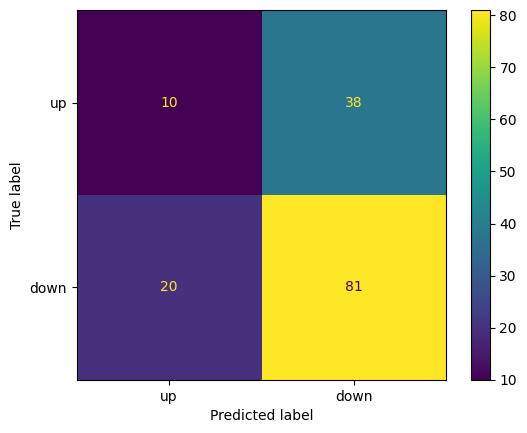

In [349]:
cm = confusion_matrix(y_test, outsample_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up', 'down'])
disp.plot()
plt.show()

In [329]:
misclassifications = (outsample_predict != y_test).tolist()


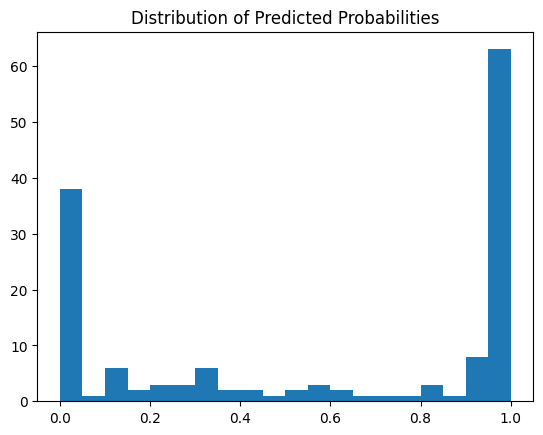

In [ ]:
plt.hist(x = outsample_prob, bins = 20)
plt.title("Distribution of Predicted Probabilities")
plt.show()

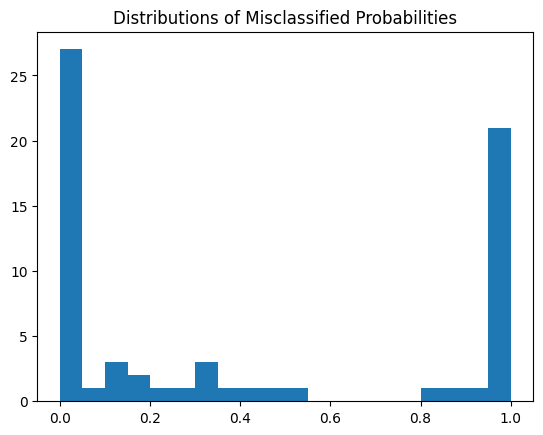

In [ ]:
plt.hist( x= pd.Series(outsample_prob.flatten())[misclassifications], bins = 20)
plt.title("Distributions of Misclassified Probabilities")
plt.show()